## Install Package yang diperlukan

In [1]:
!pip install jcopdl
!pip install tqdm

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=5f71ce21844c3facd0192c58445c318a8c641267716e6a420a74546845395432
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


## Import Package yang diperlukan

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block
from jcopdl.layers import linear_block, conv_block

from google.colab import files
import zipfile,os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Download Datasets dan Ekstraksi

In [5]:
!unrar x "/content/drive/My Drive/datasets/Intel_Image_Classification.rar" "/content/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/Intel_Image_Classification/train/sea/3497.jpg        70%  OK 
Extracting  /content/Intel_Image_Classification/train/glacier/3498.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/buildings/3499.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/35.jpg       70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3500.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3501.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3503.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/sea/3504.jpg        70%  OK 
Extracting  /content/Intel_Image_Classification/train/street/3505.jpg      70%  OK 
Extracting  /content/Intel_Image_Classification/train/buildings/3506.jpg      70%  OK 
Extracting  /co

## Datasest dan DataLoader

In [6]:
bs = 32
crop_size = 64

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("/content/intel_image/Intel_Image_Classification/train/", transform=transform_train)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True)

test_set = datasets.ImageFolder("/content/intel_image/Intel_Image_Classification/test/", transform=transform_test)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
# Cek Data
images, label = next(iter(trainloader))
images.shape

torch.Size([32, 3, 64, 64])

In [8]:
# label
label2cat = train_set.classes
label2cat

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [9]:
len(label2cat)

6

## Arsitektur CNN

In [10]:
class IntelCNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, output_size, drout):
        super().__init__()
        self.conv = nn.Sequential(
            # 3x64x64
            nn.Conv2d(3, 32, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            # 32x32x32
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #64x16x16
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            #128x8x8
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden1),
            nn.ReLU(),
            nn.Dropout(drout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(drout),
            nn.Linear(hidden2, output_size),
            nn.LogSoftmax()
        )
        
    def forward(self, x):
        return self.fc(self.conv(x))

In [11]:
# set config
config = set_config({
    "bs" : 32,
    "crop_size" : 64,
    "input_layer" : 8192,
    "hidden1" : 1024,
    "hidden2" : 64,
    "output_size" : len(label2cat),
    "drout" : 0.3
})

In [12]:
model = IntelCNN(config.input_layer, config.hidden1, config.hidden2, config.output_size, config.drout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)
callback = Callback(model, config, outdir="model_weight", early_stop_patience=8, plot_every=100)

## Proses Training

In [13]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




Epoch     1
Train_cost  = 1.2164 | Test_cost  = 0.9215 | Train_score = 0.5230 | Test_score = 0.6453 |




Epoch     2
Train_cost  = 0.9528 | Test_cost  = 0.8611 | Train_score = 0.6417 | Test_score = 0.6593 |




Epoch     3
Train_cost  = 0.8492 | Test_cost  = 0.6812 | Train_score = 0.6876 | Test_score = 0.7587 |




Epoch     4
Train_cost  = 0.7865 | Test_cost  = 0.7307 | Train_score = 0.7146 | Test_score = 0.7433 |
==> EarlyStop patience =  1 | Best test_score: 0.7587




Epoch     5
Train_cost  = 0.7358 | Test_cost  = 0.6468 | Train_score = 0.7352 | Test_score = 0.7597 |




Epoch     6
Train_cost  = 0.7003 | Test_cost  = 0.6361 | Train_score = 0.7509 | Test_score = 0.7740 |




Epoch     7
Train_cost  = 0.6652 | Test_cost  = 0.5955 | Train_score = 0.7633 | Test_score = 0.7907 |




Epoch     8
Train_cost  = 0.6459 | Test_cost  = 0.6140 | Train_score = 0.7708 | Test_score = 0.7837 |
==> EarlyStop patience =  1 | Best test_score: 0.7907




Epoch     9
Train_cost  = 0.6139 | Test_cost  = 0.6166 | Train_score = 0.7799 | Test_score = 0.7757 |
==> EarlyStop patience =  2 | Best test_score: 0.7907




Epoch    10
Train_cost  = 0.6025 | Test_cost  = 0.5270 | Train_score = 0.7872 | Test_score = 0.8197 |




Epoch    11
Train_cost  = 0.5917 | Test_cost  = 0.5569 | Train_score = 0.7913 | Test_score = 0.8013 |
==> EarlyStop patience =  1 | Best test_score: 0.8197




Epoch    12
Train_cost  = 0.5804 | Test_cost  = 0.6078 | Train_score = 0.7983 | Test_score = 0.7950 |
==> EarlyStop patience =  2 | Best test_score: 0.8197




Epoch    13
Train_cost  = 0.5480 | Test_cost  = 0.5764 | Train_score = 0.8055 | Test_score = 0.8053 |
==> EarlyStop patience =  3 | Best test_score: 0.8197




Epoch    14
Train_cost  = 0.5580 | Test_cost  = 0.5175 | Train_score = 0.8028 | Test_score = 0.8117 |
==> EarlyStop patience =  4 | Best test_score: 0.8197




Epoch    15
Train_cost  = 0.5417 | Test_cost  = 0.5857 | Train_score = 0.8072 | Test_score = 0.7800 |
==> EarlyStop patience =  5 | Best test_score: 0.8197




Epoch    16
Train_cost  = 0.5345 | Test_cost  = 0.5083 | Train_score = 0.8085 | Test_score = 0.8260 |




Epoch    17
Train_cost  = 0.5174 | Test_cost  = 0.5667 | Train_score = 0.8193 | Test_score = 0.8173 |
==> EarlyStop patience =  1 | Best test_score: 0.8260




Epoch    18
Train_cost  = 0.5056 | Test_cost  = 0.5514 | Train_score = 0.8201 | Test_score = 0.8190 |
==> EarlyStop patience =  2 | Best test_score: 0.8260




Epoch    19
Train_cost  = 0.4940 | Test_cost  = 0.5093 | Train_score = 0.8254 | Test_score = 0.8260 |
==> EarlyStop patience =  3 | Best test_score: 0.8260




Epoch    20
Train_cost  = 0.4836 | Test_cost  = 0.5304 | Train_score = 0.8327 | Test_score = 0.8187 |
==> EarlyStop patience =  4 | Best test_score: 0.8260




Epoch    21
Train_cost  = 0.4959 | Test_cost  = 0.5494 | Train_score = 0.8246 | Test_score = 0.8073 |
==> EarlyStop patience =  5 | Best test_score: 0.8260




Epoch    22
Train_cost  = 0.4685 | Test_cost  = 0.5332 | Train_score = 0.8355 | Test_score = 0.8160 |
==> EarlyStop patience =  6 | Best test_score: 0.8260




Epoch    23
Train_cost  = 0.4702 | Test_cost  = 0.5935 | Train_score = 0.8338 | Test_score = 0.7990 |
==> EarlyStop patience =  7 | Best test_score: 0.8260




Epoch    24
Train_cost  = 0.4613 | Test_cost  = 0.5518 | Train_score = 0.8396 | Test_score = 0.8160 |
==> EarlyStop patience =  8 | Best test_score: 0.8260
==> Execute Early Stopping at epoch: 24 | Best test_score: 0.8260
==> Best model is saved at model_weight


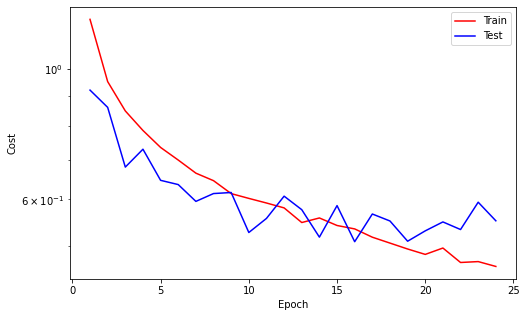

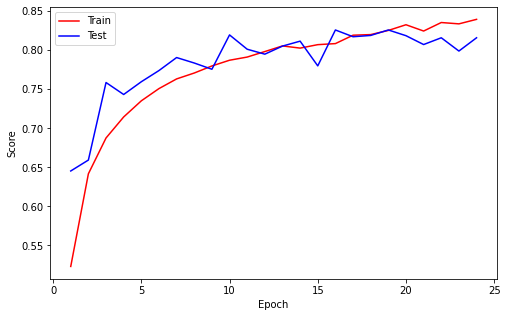

In [14]:

while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

## Prediksi

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

preds

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([1, 0, 3, 2, 2, 4, 5, 4, 3, 4, 2, 5, 5, 1, 5, 5, 1, 4, 0, 5, 2, 3, 1, 0,
        5, 1, 5, 5, 1, 5, 4, 1], device='cuda:0')

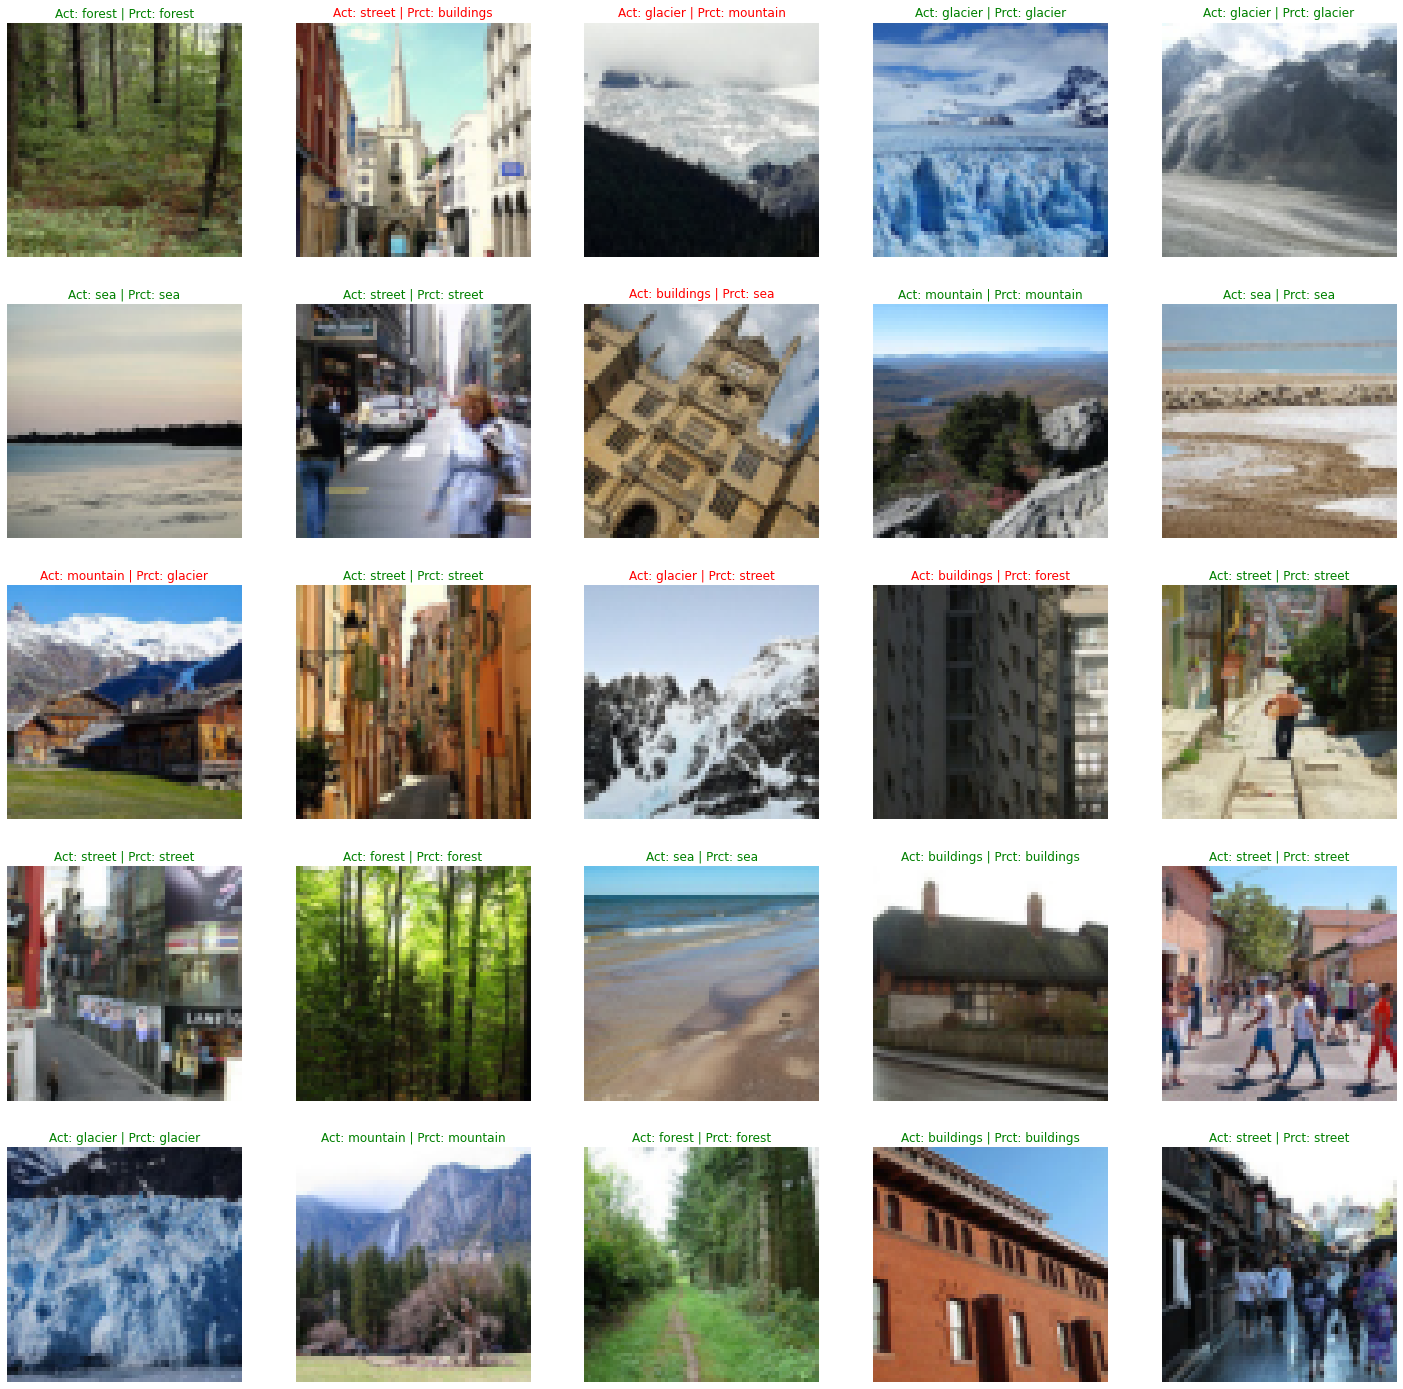

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(25, 25))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color":"r"} if label != pred else {"color":"g"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Act: {label} | Prct: {pred}", fontdict=font);
    ax.axis('off');